**Before starting:**

You need to install Basemap. Do it only once.

In [1]:
!pip install basemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.9/863.9 KB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.23.5 which is incompatible.


**Goal of this practice:**

In this second practice, we will use the "BigQuery" technology which uses a network of computers at Google. We still use the Google Colab to run this Jupyter notebook and interact with the Google Cloud Platform. We will work directly on the whole database (1998-2015, 150Go) and you will perform basic statistics. The idea is to show that BigQuery is able to manage very large datasets efficiently (few seconds). We will manipulate the SST/SSH dataset with BigQuery using the magic command *%%bigquery*.

**Import libraries:**

- matplotlib (2D plotting)
- pylab (scientific computing)
- basemap (plotting 2D data on maps)
- scikit-learn (machine learning)
- pandas (data structures and data analysis tools)

In [2]:
%matplotlib inline
%pylab inline
from mpl_toolkits.basemap import Basemap
import sklearn
import pandas as pd
from scipy.stats.mstats import zscore
import warnings
warnings.filterwarnings("ignore") # disable warnings
pylab.rcParams['figure.figsize']=(15,15) # graph size

Populating the interactive namespace from numpy and matplotlib


**Declare functions:**
- plot_im (plot satellite image with geographic coordinates)
- plot_ts (plot time series)

In [3]:
# function to plot images  
def plot_im(lon,lat,im,size_points,var_name):
    
    # transform to arrays (just in case)
    lon=array(lon)
    lat=array(lat)
    im=array(im)
    
    if max(lon)-min(lon)<100:
      # Mercator projection (for small zone)
      m=Basemap(projection='merc',llcrnrlat=nanmin(lat),urcrnrlat=nanmax(lat),\
                llcrnrlon=nanmin(lon),urcrnrlon=nanmax(lon),lat_0=(nanmax(lat)+nanmin(lat))*0.5,\
                lon_0=(nanmax(lon)+nanmin(lon))*0.5,resolution='l')
    else:
      # Orthogonal projection (for large zone)
      m=Basemap(projection='robin',lat_0=0,lon_0=0,resolution='l')
    # you can use other projections (see https://matplotlib.org/basemap/users/mapsetup.html)
    
    # transform (lon,lat) to (x,y)
    x,y=m(lon,lat)

    # plot
    #im=ma.masked_where(isnan(im),im)
    res=m.scatter(x,y,size_points,im,'o',alpha=1,cmap='jet',lw=0)
    m.drawcoastlines()
    m.fillcontinents()
    parallels = linspace(nanmin(lat),nanmax(lat),15)
    meridians = linspace(nanmin(lon),nanmax(lon),15)
    #m.drawparallels(parallels,labels=[1,0,0,1],fontsize=10)
    #m.drawmeridians(meridians,labels=[1,0,0,1],fontsize=10)
    cb=m.colorbar(res,location="right")
    cb.set_label(var_name,fontsize=15)
    
# function to plot time series
def plot_ts(time,ts,line_type,var_name):

    # plot
    plot_date(time,ts,line_type)
    xlabel('Time',fontsize=15)
    ylabel(var_name,fontsize=15)

**Connection to the GCP:**

First, we have to connect to the Google Cloud Platform. Enter the login "bigdataocean2020@gmail.com" and password "bdoimt2023". Do it only once. We will maybe need an authentication: contact me at pierre.tandeo@imt-atlantique.fr.

In [4]:
import os
os.environ['USE_AUTH_EPHEM'] = '0'

from google.colab import auth
auth.authenticate_user()

The Google Cloud Platform has set up a tool to handle large databases. This is called "BigQuery" and it is based on the NoSQL ("Not only SQL") language. The syntaxe in BigQuery is very similar to the pandas example given in the first practice. SQL language is suitable to manipulate and compute basic statistics such as the mean, standard deviation, minimum, maximum, correlation, etc... Here you will find the list of basic functions: https://cloud.google.com/bigquery/docs/reference/legacy-sql?hl=fr.

In the example below, we plot the mean SST map in the Mediterranean Sea over the period 1998-2015. The full 18-years dataset is stored in the BigQuery table *bdo2020.bdo2020.1998_2015*. The project is called *alert-ground-261008* (strange but you have to provide it). The result of the BigQuery request is stored in the *output* dataframe. 

In [5]:
%%bigquery output --project alert-ground-261008
SELECT lon, lat, AVG(sst) AS mean_sst
FROM bdo2020.bdo2020.1998_2015
WHERE lon>0 AND lon<35 AND lat>30 AND lat<45
GROUP BY lon, lat

Query is running:   0%|          |

Downloading:   0%|          |

In [6]:
# sample of the dataframe
output

,lon,lat,mean_sst
0,18.125,35.375,21.216261
1,18.875,36.375,20.996098
2,16.375,37.125,20.941930
3,0.875,37.375,20.044828
4,1.125,37.625,20.053019
...,...,...,...
1718,11.375,40.875,19.792352
1719,4.625,41.625,18.134129
1720,4.625,42.125,17.657890
1721,5.375,42.375,17.617382


Text(0.5, 1.0, 'Mean over the years 1998-2015')

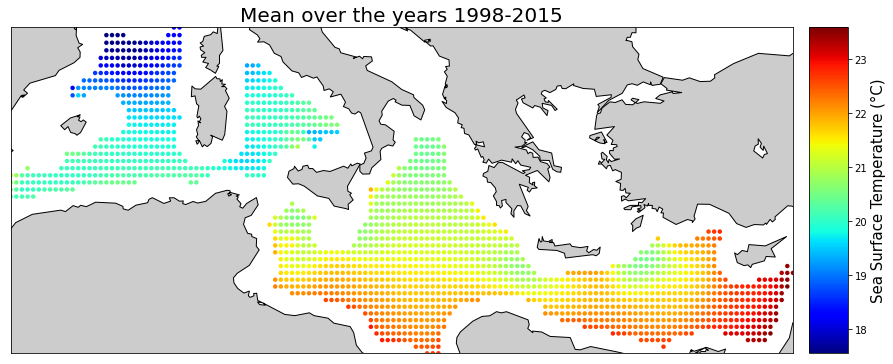

In [7]:
plot_im(output.lon, output.lat, output.mean_sst, 20, 'Sea Surface Temperature (°C)')
title('Mean over the years 1998-2015', size=20)

**Part 1)**

Plot the global maps of mean SST, mean SSH and correlation SST/SSH for the period 1998-2015.

In [8]:
%%bigquery output --project alert-ground-261008
SELECT lon, lat, AVG(sst) AS mean_sst, AVG(ssh) AS mean_ssh
FROM bdo2020.bdo2020.1998_2015
GROUP BY lon, lat

Query is running:   0%|          |

Downloading:   0%|          |

In [10]:
# sample of the dataframe
output

,lon,lat,mean_sst,mean_ssh
0,200.375,21.125,25.804221,1.015825
1,306.375,22.625,26.469455,0.596070
2,14.625,-35.375,18.355400,0.497861
3,166.625,-32.375,19.774445,0.788899
4,200.125,-30.875,20.439451,0.809753
...,...,...,...,...
563962,347.875,83.125,-1.800000,-0.207229
563963,306.875,-70.375,-1.800000,-1.324718
563964,311.375,-73.125,-1.800000,-1.251183
563965,311.625,-73.125,-1.800000,-1.252750


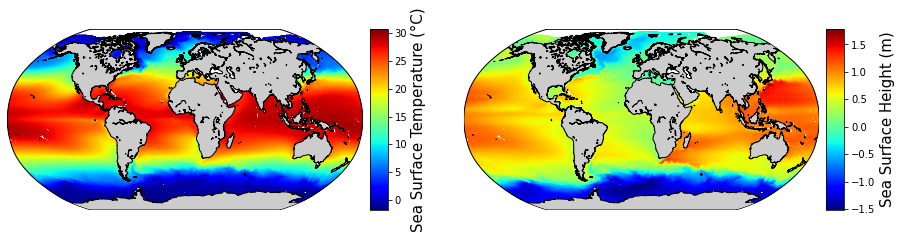

In [11]:
figure()
subplot(1,2,1)
plot_im(output.lon,output.lat,output.mean_sst,1,'Sea Surface Temperature (°C)')
subplot(1,2,2)
plot_im(output.lon,output.lat,output.mean_ssh,1,'Sea Surface Height (m)')

**Part 2)**

Plot the mean and standard deviation SST time series for the period 1998-2015 in the Equatorial zone between latitudes (-30,+30).

In [37]:
%%bigquery output --project alert-ground-261008
SELECT time, AVG(sst) AS mean_sst, STDDEV(sst) AS std_sst
FROM bdo2020.bdo2020.1998_2015
WHERE lat>-30 AND lat<30
GROUP BY time
ORDER BY time

Query is running:   0%|          |

Downloading:   0%|          |

In [38]:
# sample of the dataframe
output

,time,mean_sst,std_sst
0,729390.0,26.331851,2.584938
1,729391.0,26.278581,2.594892
2,729392.0,26.243598,2.604753
3,729393.0,26.242813,2.599236
4,729394.0,26.233886,2.575057
...,...,...,...
6569,735959.0,26.464220,2.628212
6570,735960.0,26.447705,2.610540
6571,735961.0,26.459063,2.575203
6572,735962.0,26.458360,2.569552


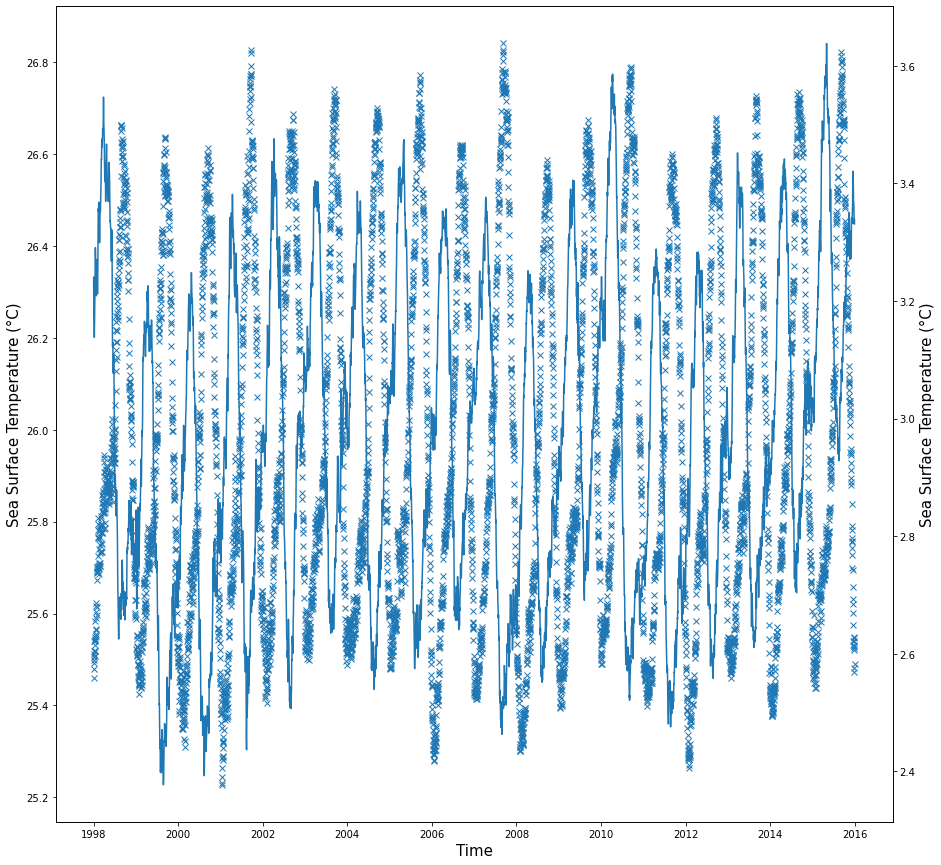

In [42]:
plot_ts(output.time,output.mean_sst,'-','Sea Surface Temperature (°C)')
twinx()
plot_ts(output.time,output.std_sst,'x','Sea Surface Temperature (°C)')

**Part 3)**

Extract a random sample of data (1%) in the Agulhas current between longitude (+42,+46) and latitude (-40,-36) for the period 1998-2015. Then draw the scatterplot between SST and SSH (use a 2D histogram for a better visualization).

In [43]:
%%bigquery output --project alert-ground-261008
SELECT lon, lat, AVG(sst) AS mean_sst, AVG(ssh) AS mean_ssh
FROM bdo2020.bdo2020.1998_2015
WHERE lon>42 AND lon<46 AND lat>-40 AND lat<-36 AND Rand() < 0.01
GROUP BY lon, lat

Query is running:   0%|          |

Downloading:   0%|          |

In [44]:
# sample of the dataframe
output

,lon,lat,mean_sst,mean_ssh
0,42.625,-36.875,18.641129,1.108510
1,44.125,-36.125,18.829545,1.028979
2,45.375,-37.375,18.162500,1.074960
3,44.125,-39.625,17.036441,0.685158
4,44.875,-39.875,17.158163,0.740592
...,...,...,...,...
251,42.125,-37.625,18.519403,1.069319
252,42.625,-36.375,18.643750,1.067893
253,45.875,-37.375,18.365909,1.024035
254,42.625,-39.875,16.757609,0.694650


Text(0, 0.5, 'Sea Surface Height (m)')

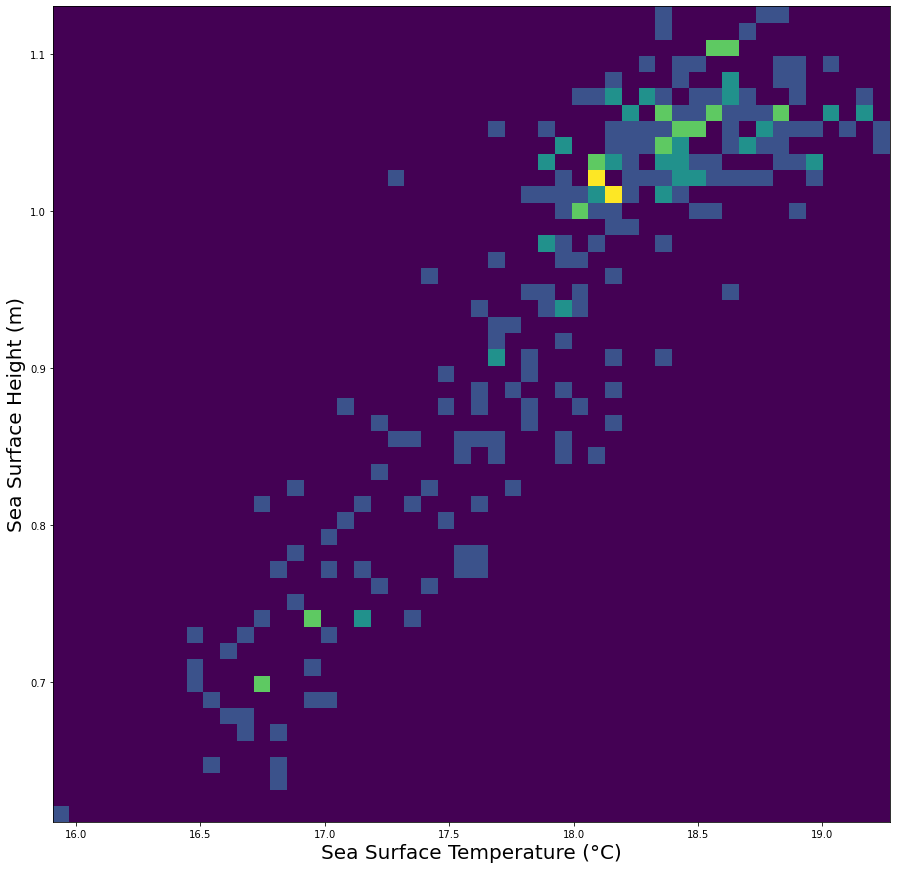

In [45]:
hist2d(output.mean_sst,output.mean_ssh,50)
xlabel('Sea Surface Temperature (°C)', size=20)
ylabel('Sea Surface Height (m)', size=20)

**Part 4)**

Count the number of pixels contaminated by ice every day in the Hudson Bay between longitude (+264,+285) and latitude (+52,+65) for the period 1998-2015.

Be careful, a negative SST doesn't mean that there is ice. There is ice when there is no SST data available.

In [50]:
%%bigquery output --project alert-ground-261008
SELECT time, COUNT(sst) AS count_sst
FROM bdo2020.bdo2020.1998_2015
WHERE lon>264 AND lon<285 AND lat>52 AND lat<65
GROUP BY time
ORDER BY time

Query is running:   0%|          |

Downloading:   0%|          |

In [51]:
# sample of the dataframe
output

,time,count_sst
0,731002.0,609
1,731003.0,634
2,731004.0,660
3,731005.0,668
4,731006.0,687
...,...,...
3382,735959.0,823
3383,735960.0,820
3384,735961.0,820
3385,735962.0,804


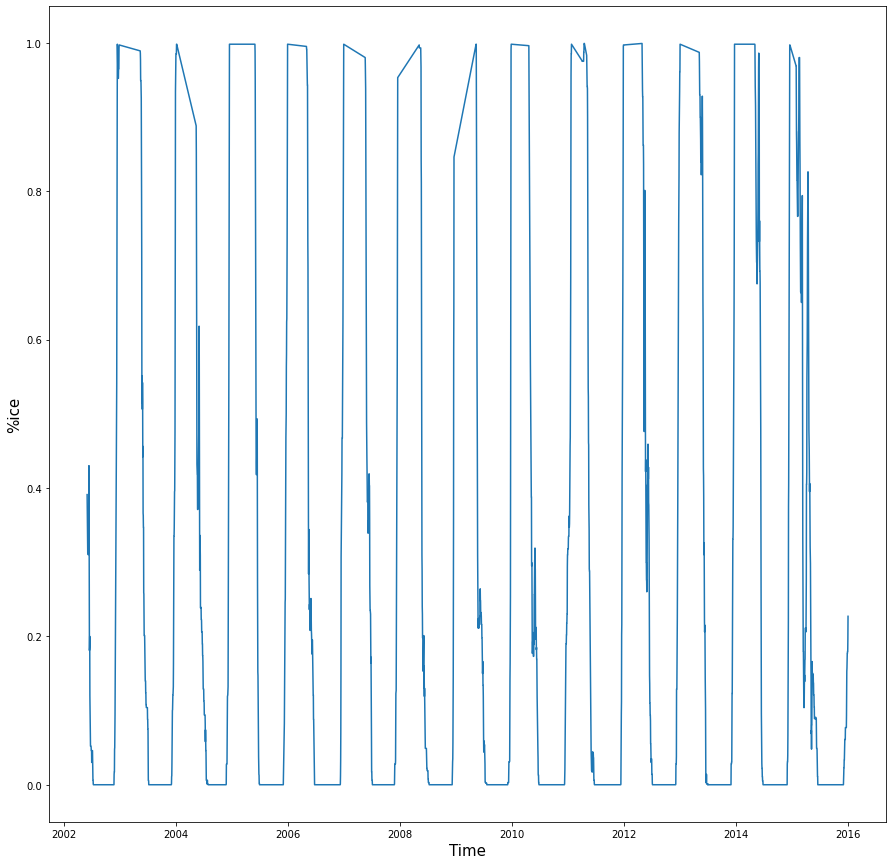

In [70]:
num_max = max(output.count_sst)
per_ice = 1-(output.count_sst / num_max)
plot_ts(ravel(output.time),ravel(per_ice),'-','%ice')

**Part 5)**

Compute the mean seasonal cycle of the SST and SSH in the Red Sea, between longitudes (+32,+45) and latitudes (+13,+30), for the period 1998-2015.

In [79]:
%%bigquery output --project alert-ground-261008
SELECT dayofyear, AVG(sst) AS mean_sst
FROM bdo2020.bdo2020.1998_2015_withtimes
WHERE lon>32 AND lon<45 AND lat>13 AND lat<30
GROUP BY dayofyear
ORDER BY dayofyear

Query is running:   0%|          |

Downloading:   0%|          |

In [80]:
# sample of the dataframe
output

,dayofyear,mean_sst
0,1,27.889368
1,2,27.854981
2,3,27.813985
3,4,27.798659
4,5,27.727874
...,...,...
361,362,28.049808
362,363,28.023180
363,364,27.983621
364,365,27.942337


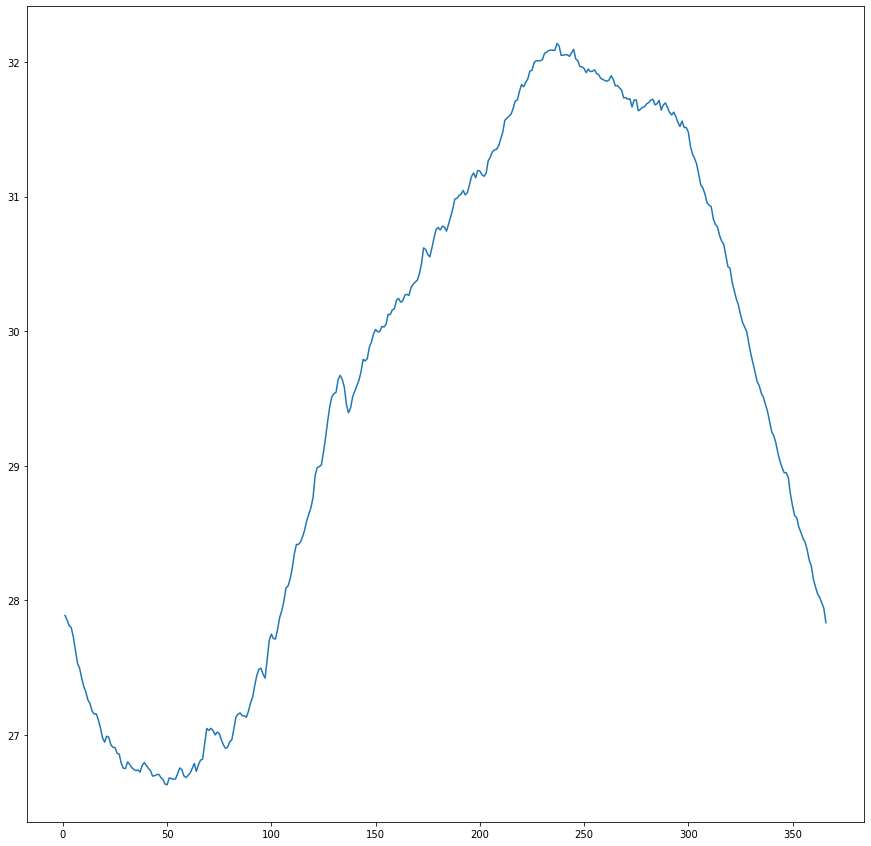

In [88]:
plot(ravel(output.dayofyear),ravel(output.mean_sst),'-')